In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
import seaborn as sns
from joblib import delayed, Parallel

import sys
sys.path.append("../../")

import tetrahedron
import proj_quality
from metric.metric import Euclid

import pivot_selection
import point_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from joblib import Memory
mem = Memory("~/.cache/joblib/", verbose=0)
tetrahedron.project_to_2d_euclidean = mem.cache(tetrahedron.project_to_2d_euclidean)

In [11]:
metric = Euclid(2)
DEFAULT_SAMPLE_SIZE = 120

generators = point_generator.get_generator_dict()
piv_selectors = pivot_selection.get_selection_algos(True)

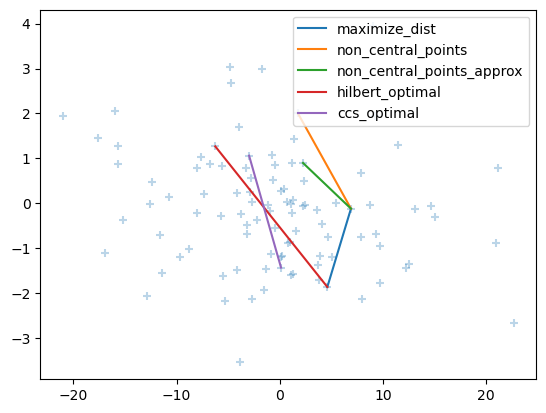

In [12]:
rng = np.random.default_rng(0xfeed)
points = point_generator.generate_gaussian_points(rng, dim=15, n_samples=100)

test_algs = {i:piv_selectors[i] for i in (
    "maximize_dist",
    "non_central_points",
    "non_central_points_approx",
    "hilbert_optimal",
    "ccs_optimal",
    )}

plt.scatter(points[:,0], points[:,1], alpha=0.3, marker="+")

for name, piv_func in test_algs.items():
    exact = np.array(piv_func(points, rng=rng))
    plt.plot(exact[:,0], exact[:,1], label=name)
    

plt.legend()

In [19]:
def compare_projections(point_gen:dict, pivot_selector:dict, dims:list, seed=0, errors="skip"):
    rv = []
    rng = np.random.default_rng(seed)
    for dim in dims:
        for gen_name, gen_func in point_gen.items():
            points = gen_func(dim=dim, rng=rng)
            r = proj_quality.get_average_k_nn_dist(points, metric, k=10)
            for algo_name, select_pivots in pivot_selector.items():
                def doit():
                    p0, p1 = select_pivots(points, rng=rng)
                    points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, metric)
                    rv.append(dict(
                        dim=dim,
                        dataset=gen_name,
                        algorithm=algo_name,
                        mean_candidate_set_size=proj_quality.candidate_set_size(points_p,r,metric),
                        hilbert_quality=proj_quality.hilbert_quality(points_p,r),
                        note=""
                    ))
                if errors == "skip":
                    try:
                        doit()
                    except:
                        rv.append(dict(
                            dim=dim,
                            dataset=gen_name,
                            algorithm=algo_name,
                            mean_candidate_set_size=-1,
                            hilbert_quality=-1,
                            note="failed",
                        ))
                elif errors == "raise":
                    doit()
                else:
                    raise NotImplementedError()
    rv = pd.DataFrame(rv)
    return rv

In [20]:
def aggregate_runs(results):
    def to_ufloat(data):
        return ufloat(np.mean(data), np.std(data,ddof=1))
    rv = results.drop(columns="run").groupby("algorithm").agg(to_ufloat)
    return rv

In [ ]:
dims = range(2, 17)
sampels = range(16)

for global_run in range(1000):
    print(f"starting global run {global_run}…")
    def run(run_id):
        r = compare_projections(generators, algs, dims, seed=global_run*1000+run_id)
        r["run"] = run_id
        return r
    
    jobs = [delayed(run)(run_id) for run_id in sampels]
    results = pd.concat(Parallel(n_jobs=16, verbose=11)(jobs))
    results.to_csv(f"./results_total_{global_run}.csv")

starting global run 0…


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


In [48]:
results.to_csv("./results_long.csv")

In [49]:
results

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,note,run
0,2,"univariate, idd",random,10.794,0.945,NaN,0
1,2,"univariate, idd",maximize_dist,14.234,0.949,NaN,0
2,2,"univariate, idd",non_central_points,8.998,0.945,NaN,0
3,2,"univariate, idd",remoteness,8.926,0.945,NaN,0
4,2,"univariate, idd",central_and_distant,11.368,0.948,NaN,0
...,...,...,...,...,...,...,...
541,14,"clusters, sparse",non_central_points,258.048,0.543,NaN,199
542,14,"clusters, sparse",remoteness,258.048,0.543,NaN,199
543,14,"clusters, sparse",central_and_distant,249.030,0.500,NaN,199
544,14,"clusters, sparse",different_cluster_centers,250.802,1.000,NaN,199


In [19]:
def _normalize(df):
    df = df[df.note != "failed"].copy()
    random = df.query("algorithm == 'random'")
    df.hilbert_quality -= random.hilbert_quality.mean()

    best = df.query("algorithm == 'optimized_hq'")
    if len(best):
        df.hilbert_quality /= best.hilbert_quality.mean()
    df.mean_candidate_set_size /= random.mean_candidate_set_size.mean()
    return df

drop_ratio = 0.25
measure = "hilbert_quality"
def _drop_worst(group:pd.DataFrame):
    thresh = group[measure].quantile(drop_ratio)
    return group[group[measure] > thresh]
    
normalized_res = results.groupby(["dim","dataset", "algorithm"]).apply(_drop_worst, include_groups=False)
normalized_res = normalized_res.reset_index()#.drop(columns="level_2")
assert np.allclose(1-len(normalized_res)/len(results), drop_ratio,atol=0.05)

normalized_res = results.groupby(["dataset","dim"]).apply(_normalize, include_groups=False)
normalized_res = normalized_res.reset_index().drop(columns="level_2")

AssertionError: 

In [20]:
measure = "hilbert_quality"
def _discard_if_worse_than_random(group):
    group = group.reset_index(drop=True)
    mean = group.groupby("algorithm")[measure].mean()
    std =  group.groupby("algorithm")[measure].std()
    thresh = mean["random"] - std["random"]
    discard = mean.index[mean < thresh]
    return group[~group.algorithm.isin(discard)]

# drop stuff worse than random
normalized_res = normalized_res.groupby(["dim","dataset"]).apply(_discard_if_worse_than_random, include_groups=False)#.reset_index(drop=False)
normalized_res = normalized_res.reset_index().drop(columns="level_2")

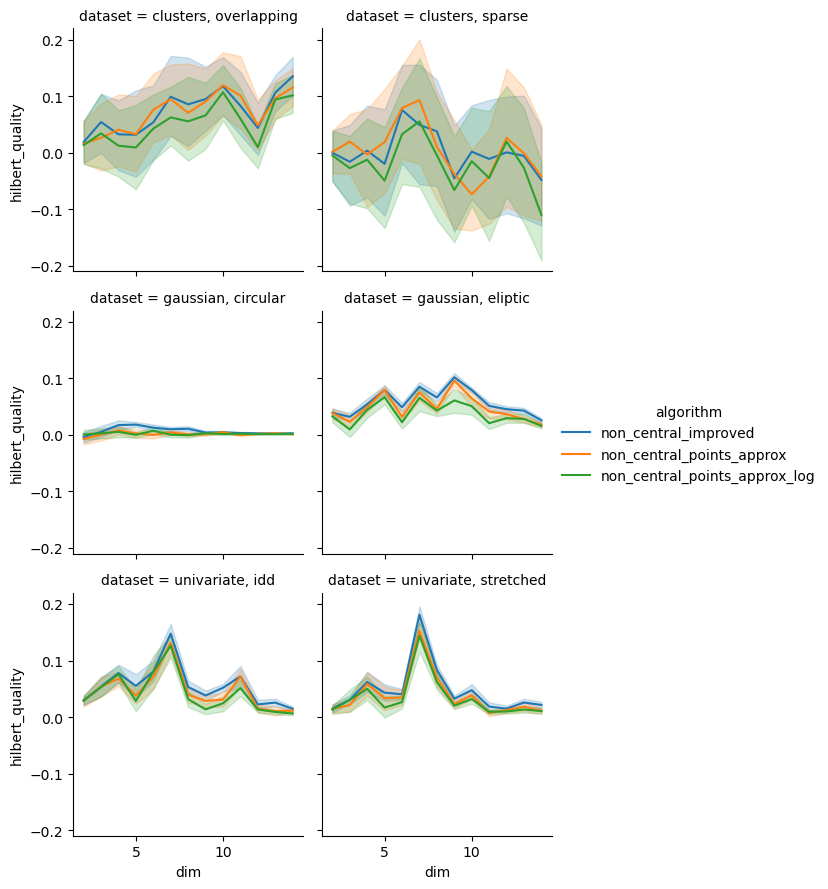

In [28]:
g = sns.FacetGrid(normalized_res[normalized_res.algorithm.isin(["non_central_improved","non_central_points_approx", "non_central_points_approx_log"])]
                  , col="dataset", hue="algorithm", col_wrap=2,
                 )
g.map(sns.lineplot, "dim", "hilbert_quality",errorbar="ci")#.set(ylim=(-0.2,1.1))
g.add_legend()
g.savefig("fig/hilbert_quality_200.svg")

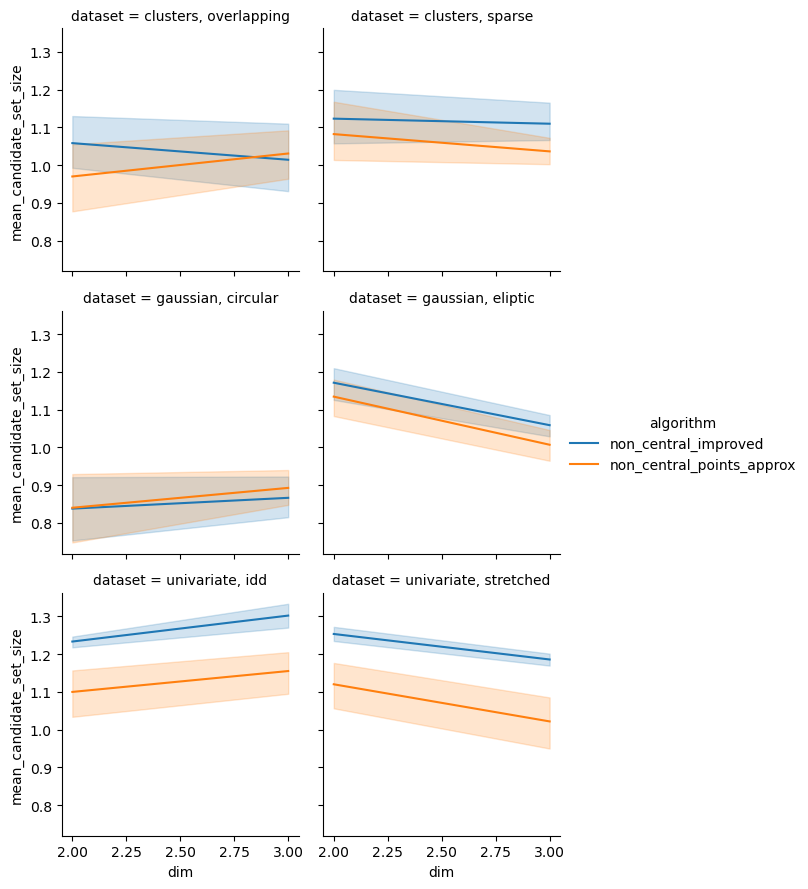

In [16]:
g = sns.FacetGrid(normalized_res[normalized_res.algorithm.isin(["non_central_improved","non_central_points_approx"])]
                  , col="dataset", hue="algorithm", col_wrap=2)
g.map(sns.lineplot, "dim", "mean_candidate_set_size")
g.add_legend()
g.savefig("fig/candidate_set_size_200.svg")

In [ ]:
    maximize_dist=max_dist_points,
    non_central_points=two_least_central,
    non_central_improved=low_centrality_and_far_away,
    non_central_points_approx=two_least_central_heuristically,
    non_central_points_approx_log=lambda *args,**kwargs:two_least_central_heuristically(
        *args,**kwargs, budget=lambda x:np.log(x)),

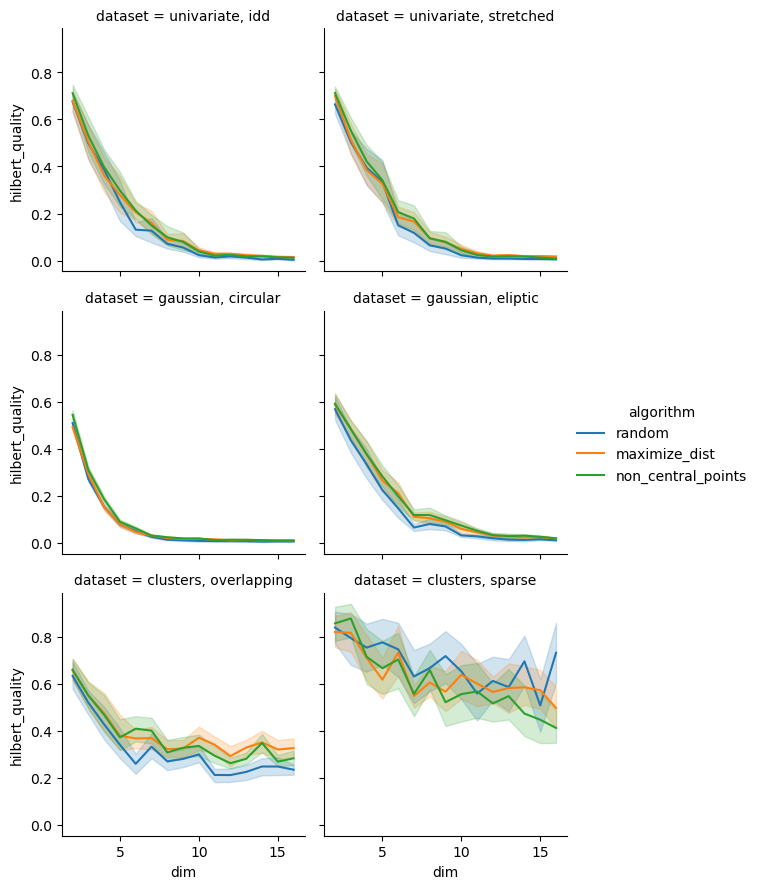

In [25]:
g = sns.FacetGrid(results, col="dataset", hue="algorithm", col_wrap=2,
                 )
g.map(sns.lineplot, "dim", "hilbert_quality",errorbar="ci")#.set(ylim=(-0.2,1.1))
g.add_legend()
g.savefig("fig/hilbert_quality_200.svg")

In [22]:
results.to_csv("optimized-comparison.csv")

In [6]:
piv_selectors.keys()

dict_keys(['random', 'maximize_dist', 'non_central_points', 'non_central_points_approx', 'remoteness', 'central_and_distant', 'different_cluster_centers', 'hilbert_optimal', 'ccs_optimal'])

In [23]:
dims = range(2,17)
sampels = range(16)

test_algs = {i:piv_selectors[i] for i in
    ["random",
    "maximize_dist",
    "non_central_points",  ] 
            }

def run(run_id):
    r = compare_projections(generators, test_algs, dims, seed=100+run_id, errors="raise")
    r["run"] = run_id
    return r

jobs = [delayed(run)(run_id) for run_id in sampels]
results = pd.concat(Parallel(n_jobs=1, verbose=11)(jobs))

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Do

In [24]:
results

,dim,dataset,algorithm,mean_candidate_set_size,hilbert_quality,note,run
0,2,"univariate, idd",random,15.000000,0.541667,,0
1,2,"univariate, idd",maximize_dist,15.233333,0.575000,,0
2,2,"univariate, idd",non_central_points,15.133333,0.583333,,0
3,2,"univariate, stretched",random,12.100000,0.766667,,0
4,2,"univariate, stretched",maximize_dist,14.983333,0.783333,,0
...,...,...,...,...,...,...,...
265,16,"clusters, overlapping",maximize_dist,45.616667,0.250000,,15
266,16,"clusters, overlapping",non_central_points,66.300000,0.250000,,15
267,16,"clusters, sparse",random,28.450000,0.500000,,15
268,16,"clusters, sparse",maximize_dist,35.150000,0.500000,,15


In [ ]:
def plot_hilbert_qual(ps):
    part = proj_quality.HilbertPartitioner(ps, ten_nn_dist)
    l, r = part.get_partitions(ps)

    plt.scatter(*ps.T)
    plt.scatter(*ps[l].T, marker="+", label="left partition")
    plt.scatter(*ps[r].T, marker="x", label="right partition")
    
    hq = part.hyperplane_quality(ps)
    css = proj_quality.candidate_set_size(ps,ten_nn_dist, Euclid(2))
    plt.title(f"partitioning {hq:.0%} points\nmean CSS {css:.0f}")
    plt.legend()
    plt.tight_layout()

In [ ]:
plt.subplot(2,2,1)
plot_hilbert_qual(points_p)
plt.subplot(2,2,2)
plot_hilbert_qual(points_p_max_dist)
plt.subplot(2,2,3)
plot_hilbert_qual(points_p_min_dist)